In [1]:
!export CUDA_VISIBLE_DEVICES=1
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


from tensorflow import keras
from tensorflow.keras import layers,models,losses,metrics,datasets, utils,optimizers,callbacks
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import os
import glob
K.clear_session()
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
tf.config.list_physical_devices('CPU')
print(tf.config.list_physical_devices('GPU'))
tf.__version__


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-10-02 12:27:26.516453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 12:27:26.566486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1727886446.597313  673695 cuda_dnn.cc:8321] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1727886446.605479  673695 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 12:27:26.650707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[]
Num GPUs Available:  0


2024-10-02 12:27:29.433901: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-02 12:27:29.433931: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: localhost.localdomain
2024-10-02 12:27:29.433935: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: localhost.localdomain
2024-10-02 12:27:29.434000: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 560.28.3
2024-10-02 12:27:29.434012: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 560.28.3
2024-10-02 12:27:29.434014: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 560.28.3


# Data Loader

In [2]:
with tf.device('/CPU:0'):
    data_folders = [f'./image-impeccable-train-data-part{i}' for i in range(1, 2)]
    x_dim = 300
    y_dim = 300
    time_length = 1259

In [3]:
with tf.device('/CPU:0'):
    def rescale_volume(seismic, low=0, high=100):
        """
        Rescaling 3D seismic volumes 0-255 range, clipping values between low and high percentiles
        """
        minval = np.percentile(seismic, low)
        maxval = np.percentile(seismic, high)
        seismic = tf.clip_by_value(seismic, minval, maxval)
        seismic = ((seismic - minval) / (maxval - minval))
        # seismic = (seismic - tf.reduce_mean(seismic))/tf.math.reduce_std(seismic)
        # seismic = seismic/tf.reduce_max(tf.abs(seismic))
        return seismic

        return seismic
    def padding_up(mat):
        num = 21
        first_row = mat[0,:]
        padding = np.tile(first_row,(num,1))
        padded_matrix = np.vstack([padding,mat])
        return padded_matrix

    def padding_lr(mat):
        num1,num2 = 10,10 
        first_column = np.zeros(mat[:,0].shape[0])
        last_column = np.zeros(mat[:,-1].shape[0])
        padding_left = np.tile(first_column,(num1,1)).T
        padding_right = np.tile(last_column,(num2,1)).T
        padded_matrix = np.hstack([padding_left,mat,padding_right])
        return padded_matrix

In [4]:
with tf.device('/CPU:0'):
    def padding_up(mat):
        num = 21
        first_row = mat[0,:]
        padding = np.tile(first_row,(num,1))
        padded_matrix = np.vstack([padding,mat])
        return padded_matrix

    # Function to load data from one folder
    def load_data_from_folder(folder_path):
        inputs = []
        outputs = []
        count = 0
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            print("Data is loaded from: "+subfolder_path)
            file1_path = list(glob.iglob(subfolder_path+"/seismic_w_noise_vol*.npy"))[0]
            file2_path = list(glob.iglob(subfolder_path+"/seismicCubes_RFC_fullstack*.npy"))[0]

            
            # Load the .npy files
            input_data = np.transpose(np.load(file1_path,allow_pickle=True,mmap_mode='r+'),(2,0,1))  
            output_data = np.transpose(np.load(file2_path,allow_pickle=True,mmap_mode='r+'),(2,0,1)) 
            # print(input_data.shape)
            # print(output_data.shape)
            
            # Create 300 training samples from each .npy file
            for i in range(x_dim):
                inputs.append(input_data[i, :, :])  # Shape: (300, 1259)
                outputs.append(output_data[i, :, :])  # Shape: (300, 1259)
            count += 1

            if count==1:
                break
        
        return np.array(inputs), np.array(outputs)

Data is loaded from: ./image-impeccable-train-data-part1/42487393
17
Batch inputs shape: (1280, 320)
Batch outputs shape: (1280, 320)


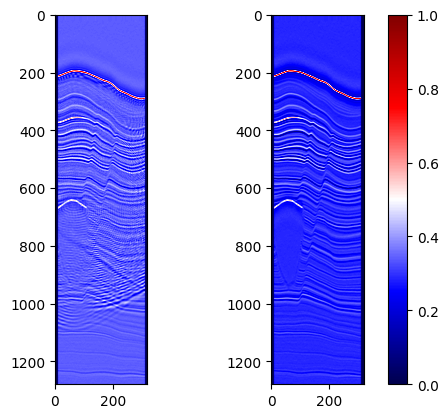

In [5]:
with tf.device('/CPU:0'):
    # Load all data from the 18 folders
    all_inputs = []
    all_outputs = []
    for folder in data_folders:
        inputs, outputs = load_data_from_folder(folder)
        all_inputs.append(inputs)
        all_outputs.append(outputs)
        break

    # Concatenate the data
    all_inputs = np.concatenate(all_inputs, axis=0)  # Shape: (N, 300, 1259)
    all_outputs = np.concatenate(all_outputs, axis=0)  # Shape: (N, 300, 1259)

    # Split into training and validation sets
    train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(all_inputs, all_outputs, test_size=0.1, random_state=42)

    # Convert to TensorFlow datasets
    def create_dataset(inputs, outputs, batch_size=32):
        dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
        dataset = dataset.shuffle(buffer_size=len(inputs))
        dataset = dataset.batch(batch_size)
        return dataset

    batch_size = 16
    train_dataset = create_dataset(train_inputs, train_outputs, batch_size)
    val_dataset = create_dataset(val_inputs, val_outputs, batch_size)
    print(len(train_dataset))

    # Example of how to use the dataset
    for batch_inputs, batch_outputs in train_dataset.take(1):
        input_section = batch_inputs[0]
        rescaled_input_section = rescale_volume(input_section)
        padded_input_section = padding_up(rescaled_input_section)
        padded_input_section = padding_lr(padded_input_section)

        output_section = batch_outputs[0]
        rescaled_output_section = rescale_volume(output_section)
        padded_output_section = padding_up(rescaled_output_section)
        padded_output_section = padding_lr(padded_output_section)

        print("Batch inputs shape:", padded_input_section.shape)
        print("Batch outputs shape:", padded_output_section.shape)
        fig,axes = plt.subplots(1,2)
        # vmin = np.min([np.min(batch_inputs[0]),np.min(batch_inputs[0])])
        # vmax = np.max([np.max(batch_inputs[0]),np.max(batch_inputs[0])])
        im1 = axes[0].imshow(padded_input_section,cmap='seismic',vmin=0,vmax=1)
        im2 = axes[1].imshow(padded_output_section,cmap='seismic',vmin=0,vmax=1)
        
        fig.colorbar(im2,ax=axes)
        plt.show()
        break
    

# Additional Layers

In [6]:

@keras.utils.register_keras_serializable()
class Rescale(layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def build(self,input_shape):
        pass

    @staticmethod
    def rescale_section(seismic, low=0, high=100):
        minval = tfp.stats.percentile(seismic, low)
        maxval = tfp.stats.percentile(seismic, high)
        seismic = tf.clip_by_value(seismic, minval, maxval)
        seismic = ((seismic - minval) / (maxval - minval))
        # seismic = (seismic - tf.reduce_mean(seismic))/tf.math.reduce_std(seismic)
        # seismic = seismic/tf.reduce_max(tf.abs(seismic))
        return seismic
    
    def call(self,inputs):
        input_sections = inputs

        def process_section(section):
            x = self.rescale_section(section)
            return x
        
        rescaled_section = tf.map_fn(process_section, input_sections, fn_output_signature=tf.float32)

        return rescaled_section
    
    def get_config(self):
        config = super().get_config()
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

(16, 1260, 300, 1) (16, 1260, 300, 1)
(1260, 300, 1)


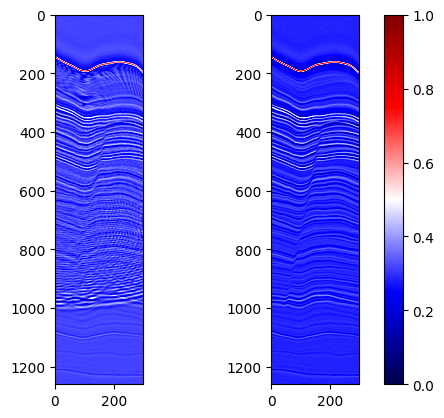

In [7]:

# Padding Layer
@keras.utils.register_keras_serializable()
class Padding(layers.Layer):
    def __init__(self,left,right, up, down,**kwargs):
        super().__init__(**kwargs)
        self.left = left
        self.right = right
        self.up = up
        self.down = down

    def build(self,input_shape):
        pass
    
    def padding_matrix(self,mat):
        # Define the padding: [[pad_top, pad_bottom], [pad_left, pad_right]]
        # padding = [[1, 1], [2, 2]]  # Example: Pad 1 row on top, 1 row on bottom, 2 columns on left, 2 columns on right
        padding = [[self.up,self.down],[self.left,self.right]]
        padded_matrix = tf.pad(mat, padding, mode='CONSTANT', constant_values=0)
        return padded_matrix
    
    def call(self,inputs):
        input_sections = inputs

        def process_section(section):
            x = self.padding_matrix(section)
            x = tf.expand_dims(x, axis=-1)
            x = tf.cast(x, dtype=tf.float32)
            return x
        
        input_sections_final = tf.map_fn(process_section, input_sections, fn_output_signature=tf.float32)
        

        return input_sections_final
        
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "left":keras.utils.serialize_keras_object(self.left),
                "right":keras.utils.serialize_keras_object(self.right),
                "up":keras.utils.serialize_keras_object(self.up),
                "down":keras.utils.serialize_keras_object(self.down)
            }
        )
        return config
    
    @classmethod
    def from_config(cls, config):
        left = keras.utils.deserialize_keras_object(config.pop("left"))
        right = keras.utils.deserialize_keras_object(config.pop("right"))
        up = keras.utils.deserialize_keras_object(config.pop("up"))
        down = keras.utils.deserialize_keras_object(config.pop("down"))
        return cls(left,right,up,down,**config)
    


# testing if the layer is working or not
rescale_layer = Rescale()
left,right, up, down = 0,0,1,0
padding_layer = Padding(left,right, up, down)
for input_sections,output_sections in train_dataset.take(1):
    
    input_sections_f,output_sections_f = padding_layer(rescale_layer(input_sections)),padding_layer(rescale_layer(output_sections))
    print(input_sections_f.shape,output_sections_f.shape)
    input_section_f,output_section_f = np.squeeze(input_sections_f[0],axis=-1),np.squeeze(output_sections_f[0],axis=-1)
    input_section_f,output_section_f = input_sections_f[0],output_sections_f[0]
    print(input_section_f.shape)


    fig,axes = plt.subplots(1,2)
    im1 = axes[0].imshow(input_section_f,cmap='seismic',vmin=0,vmax=1)
    im2 = axes[1].imshow(output_section_f,cmap='seismic',vmin=0,vmax=1)
    fig.colorbar(im2,ax=axes)

    # fig2,axes2 = plt.subplots(1,2)
    # im3 = axes2[0].imshow(input_sections[0],cmap='seismic')
    # im4 = axes2[1].imshow(output_sections[0],cmap='seismic')
    
    
    plt.show()
    break
        

(16, 1259, 300)


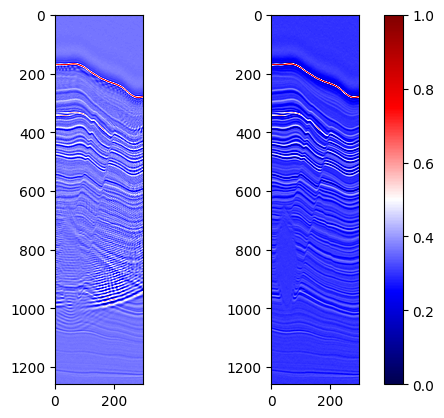

In [8]:

@keras.utils.register_keras_serializable()
class RemovePadding(layers.Layer):
    def __init__(self,left,right, up, down,**kwargs):
        super().__init__(**kwargs)
        self.left = left
        self.right = right
        self.up = up
        self.down = down

    def build(self,input_shape):
        pass

    
    def remove_padding_matrix(self,mat):
        return mat[self.up:mat.shape[0]-self.down,self.left:mat.shape[1]-self.right]

    def call(self,inputs):
        input_sections = inputs
        def process_section(section):
            x = self.remove_padding_matrix(section)
            x = tf.squeeze(x, axis=-1)
            x = tf.cast(x, dtype=tf.float32)
            return x
        
        input_sections_final = tf.map_fn(process_section, input_sections, fn_output_signature=tf.float32)

        return input_sections_final
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "left":keras.utils.serialize_keras_object(self.left),
                "right":keras.utils.serialize_keras_object(self.right),
                "up":keras.utils.serialize_keras_object(self.up),
                "down":keras.utils.serialize_keras_object(self.down)
            }
        )
        return config
    
    @classmethod
    def from_config(cls, config):
        left = keras.utils.deserialize_keras_object(config.pop("left"))
        right = keras.utils.deserialize_keras_object(config.pop("right"))
        up = keras.utils.deserialize_keras_object(config.pop("up"))
        down = keras.utils.deserialize_keras_object(config.pop("down"))
        return cls(left,right,up,down,**config)

rescale_layer = Rescale()
left,right, up, down = 0,0,1,0
padding_layer = Padding(left,right, up, down)
remove_padding_layer = RemovePadding(left,right, up, down)
for input_sections,output_sections in train_dataset.take(1):
    input_sections_f,output_sections_f = padding_layer(rescale_layer(input_sections)),padding_layer(rescale_layer(output_sections))
    input_section_f,output_section_f = remove_padding_layer(input_sections_f),remove_padding_layer(output_sections_f)
    print(input_section_f.shape)


    fig,axes = plt.subplots(1,2)
    im1 = axes[0].imshow(input_section_f[0],cmap='seismic',vmin=0,vmax=1)
    im2 = axes[1].imshow(output_section_f[0],cmap='seismic',vmin=0,vmax=1)
    fig.colorbar(im2,ax=axes)

    
    
    plt.show()
    break

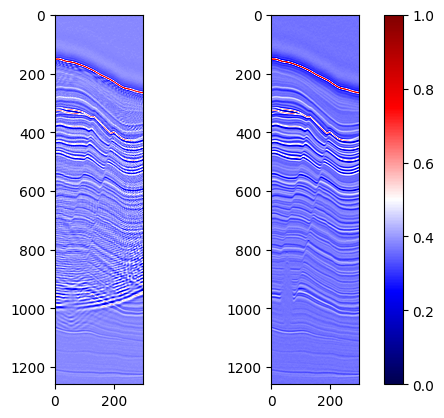

In [9]:

# testing padding layer and unpadding layer 
left,right, up, down = 0,0,1,0
model = tf.keras.Sequential([
    Rescale(),
    Padding(left,right, up, down),  # Add padding
    RemovePadding(left,right, up, down)  # Remove padding
])
for input_sections,output_sections in train_dataset.take(1):
    input_section_f,output_section_f = model(input_sections),model(output_sections)

    fig,axes = plt.subplots(1,2)
    im1 = axes[0].imshow(input_section_f[0],cmap='seismic',vmin=0,vmax=1)
    im2 = axes[1].imshow(output_section_f[0],cmap='seismic',vmin=0,vmax=1)
    fig.colorbar(im2,ax=axes)

    break

# Additional Matric and Loss function

In [10]:

# custom ssim metric
@keras.utils.register_keras_serializable()


class SSIMMetric(metrics.Metric):
    def __init__(self, max_val=1.0, name="ssim", **kwargs):
        super().__init__(name=name, **kwargs)  # Set the metric name
        self.ssim_sum = self.add_weight(name="ssim_sum", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")
        self.max_val = max_val  # Max value of the image data (1.0 if normalized)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Calculate SSIM between true and predicted values
        ssim_value = tf.image.ssim(y_true, y_pred, max_val=self.max_val)
        
        # Update the sum of SSIM values
        self.ssim_sum.assign_add(tf.reduce_sum(ssim_value))
        
        # Update the count (number of images)
        self.count.assign_add(tf.cast(tf.size(ssim_value), tf.float32))
        
        # Optionally handle sample weighting
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            ssim_value *= sample_weight

    def result(self):
        # Compute the mean SSIM
        return self.ssim_sum / self.count

    def reset_states(self):
        # Reset the SSIM sum and count variables at the start of each epoch
        self.ssim_sum.assign(0.0)
        self.count.assign(0.0)

# Example usage:
# model.compile(optimizer='adam', loss='mse', metrics=[SSIMMetric(max_val=1.0, name="custom_ssim")])



In [11]:

# Custom SSIM Loss Function as a Class
@keras.utils.register_keras_serializable()
class SSIMLoss(keras.losses.Loss):
    def __init__(self,name="ssim_loss", max_val=1.0,**kwargs):
        super().__init__(name="ssim_loss",**kwargs)
        self.max_val = max_val  # Maximum pixel value in the input images

    def call(self, y_true, y_pred):
        # Compute the SSIM between y_true and y_pred
        ssim_value = tf.image.ssim(y_true, y_pred, max_val=self.max_val)
        
        # The SSIM loss is 1 - SSIM, to maximize SSIM we minimize this loss
        return 1 - tf.reduce_mean(ssim_value)

# Model

In [12]:
@keras.utils.register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self,patch_size,**kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = layers.Reshape((-1,patch_size[0]*patch_size[1]*1)) # assuming image has one channel, each patch would be of size (patch_size[0],patch_size[1],1)


    @tf.function
    def call(self, inputs):
        
        # Extract patches using tf.image.extract_patches
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        patches = self.resize(patches)
        return patches
    
    def reconstruction_from_patches(self,patches,img_shape):
        num_patches = patches.shape[0]
        n = img_shape[0]//self.patch_size[0]
        patches = tf.reshape(patches, (num_patches, self.patch_size[0], self.patch_size[1], 1))
        rows = tf.split(patches,n,axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed


    def get_config(self):
        config = super().get_config()
        config.update({
            'patch_size': keras.utils.serialize_keras_object(self.patch_size),
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        patch_size = keras.utils.deserialize_keras_object(config.pop("patch_size"))
        return cls(patch_size,**config)
    # a nice trick to print model summary
    def summary(self):
        x = layers.Input(shape=(1260,300,1))
        mod = models.Model(inputs=[x],outputs=self(x))
        '''
        Instead of calling self.call(x) directly, you should pass the input tensor x through the layer or model instance, which will handle the symbolic nature of the tensor properly.
        '''
        return mod.summary()
    
# PATCH_SIZE = (60,15)
# patches = Patches(patch_size=PATCH_SIZE)

# left,right, up, down = 0,0,1,0
# model = tf.keras.Sequential([
#     Rescale(),
#     Padding(left,right, up, down),  # Add padding
#     #RemovePadding(left,right, up, down)  # Remove padding
# ])

# for input_sections,output_sections in train_dataset.take(1):
#     input_section_f,output_section_f = model(input_sections),model(output_sections)
#     patch_input = patches(input_section_f)
#     print(patch_input.shape)

#     reconstructed_section = patches.reconstruction_from_patches(patch_input[0],img_shape=(1260,300))
#     print(reconstructed_section.shape)

#     # for i, patch in enumerate(patch_input[0]):
#     #     # print(patch.shape)
#     #     ax = plt.subplot(1260//PATCH_SIZE[0],  300//PATCH_SIZE[1], i + 1)
#     #     patch_img = tf.reshape(patch, (PATCH_SIZE[0], PATCH_SIZE[1],1))
#     #     plt.imshow(patch_img)
#     #     plt.axis("off")
#         # break
#     break

# patches.summary()


In [13]:
@keras.utils.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self,patch_size,num_patches,projection_dim,mask_proportion,downstream=False,**kwargs):
        super().__init__(**kwargs)

        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # trainable mask toaken initialized randomly from a normal distribution
        self.mask_token = tf.Variable(tf.random.normal([1, patch_size[0] * patch_size[1] * 1]), trainable=True)
    

    def build(self,input_shape):
        # (_,self.num_patches,self.patch_area) = input_shape
        self.projection = layers.Dense(self.projection_dim)

        # positional embedding layer
        self.positon_embedding = layers.Embedding(input_dim=self.num_patches,output_dim=self.projection_dim)

        # number of patches that will be masked
        self.num_mask = int(self.mask_proportion*self.num_patches)


    def call(self,inputs): # inputs are basically patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)

        batch_size = tf.shape(inputs)[0]

        '''
        tf.newaxis is the same as using None in Python indexing and is used to add a new dimension to the tensor. 
        Specifically, positions[tf.newaxis, ...] adds an extra dimension at the beginning of positions.

        The ellipsis (...) is a shorthand for including all remaining dimensions of the tensor. 
        It means "include all the dimensions that follow."
        '''
        pos_embeddings = self.positon_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(pos_embeddings, [batch_size, 1, 1])  # (B, num_patches, projection_dim)

        patch_embeddings = self.projection(inputs) + pos_embeddings

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather all the patches that should be unmasked.

            unmasked_embeddings = tf.gather(patch_embeddings, unmask_indices, axis=1, batch_dims=1)  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them for the decoder.
            unmasked_positions = tf.gather(pos_embeddings, unmask_indices, axis=1, batch_dims=1)  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(pos_embeddings, mask_indices, axis=1, batch_dims=1)  # (B, mask_numbers, projection_dim)


            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0)

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # input to the encoder
                masked_embeddings,  # first part of input to the decoder
                unmasked_positions,  # added to the encoder outputs
                mask_indices,  # the indices that were masked
                unmask_indices,  # the indices that were unmaksed
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split it into mask and unmask indices.
        rand_indices = tf.argsort(tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1)
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]

        return mask_indices, unmask_indices
    

    def show_masked_image(self, patches, unmask_indices):
        # choose a random patch and it corresponding unmask index
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # build a numpy array of same shape as pathc
        new_patch = np.zeros_like(patch)

        # iterate of the new_patch and plug the unmasked patches
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'patch_size': keras.utils.serialize_keras_object(self.patch_size),
            'num_patches': keras.utils.serialize_keras_object(self.num_patches),
            'projection_dim': keras.utils.serialize_keras_object(self.projection_dim),
            'mask_proportion': keras.utils.serialize_keras_object(self.mask_proportion),
            'downstream': keras.utils.serialize_keras_object(self.downstream)
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        patch_size = keras.utils.deserialize_keras_object(config.pop("patch_size"))
        num_patches = keras.utils.deserialize_keras_object(config.pop("num_patches"))
        projection_dim = keras.utils.deserialize_keras_object(config.pop("projection_dim"))
        mask_proportion = keras.utils.deserialize_keras_object(config.pop("mask_proportion"))
        downstream = keras.utils.deserialize_keras_object(config.pop("downstream"))
        return cls(patch_size,num_patches,projection_dim, mask_proportion, downstream,**config)
    
    # a nice trick to print model summary
    def summary(self):
        x = layers.Input(shape=(420,900))
        mod = models.Model(inputs=[x],outputs=self(x))
        return mod.summary()
    

# rescale_layer = Rescale()
# left,right, up, down = 0,0,1,0
# padding_layer = Padding(left,right, up, down)
# remove_padding_layer = RemovePadding(left,right, up, down)

# # Define input parameters
# input_shape_before_padding = (1259, 300) # input shape after padding
# input_shape_after_padding = (input_shape_before_padding[0]+up+down, input_shape_before_padding[1]+left+right, 1)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]
# decoder_num_heads = 8
# decoder_num_layers = 4

# patch_size = (60,15)
# # Calculate the number of patches
# num_patches_height = input_shape_after_padding[0] // patch_size[0]
# num_patches_width = input_shape_after_padding[1] // patch_size[1]
# num_patches = num_patches_height * num_patches_width

# mask_proportion = 0.5
# downstream = True

# patches = Patches(patch_size=patch_size)

# patch_encoder = PatchEncoder(patch_size=patch_size,num_patches=num_patches,projection_dim=encoder_projection_dim,mask_proportion=mask_proportion,downstream=downstream)

# patch_encoder.summary()

# input_shape = (1260, 300,1)

# dummy_input = tf.random.normal([1] + list(input_shape))

# x = patches(dummy_input)
# # x = patch_encoder(x)
# print(x.shape)


In [14]:
# MLP
@keras.utils.register_keras_serializable()
class MLP(layers.Layer):
    def __init__(self,hidden_units,dropout_rate,**kwargs):
        super().__init__(**kwargs)

        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        self.dense_layers = [ layers.Dense(unit) for unit in self.hidden_units ]
        self.dropout_layers = [ layers.Dropout(self.dropout_rate) for unit in self.hidden_units ]

    def build(self,input_shape):
        pass
        
    @tf.function
    def call(self,inputs,training=False):
        x = inputs
        for dense_layer, dropout_layer in zip(self.dense_layers, self.dropout_layers):
            x = dense_layer(x)
            x = dropout_layer(x, training=training)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_units': keras.utils.serialize_keras_object(self.hidden_units),
            'dropout_rate': keras.utils.serialize_keras_object(self.dropout_rate),
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        hidden_units = keras.utils.deserialize_keras_object(config.pop("hidden_units"))
        dropout_rate = keras.utils.deserialize_keras_object(config.pop("dropout_rate"))
        return cls(hidden_units,dropout_rate,**config)
    
    # a nice trick to print model summary
    def summary(self):
        x = layers.Input(shape=(420, 900))
        mod = models.Model(inputs=[x],outputs=self(x))
        '''
        Instead of calling self.call(x) directly, you should pass the input tensor x through the layer or model instance, which will handle the symbolic nature of the tensor properly.
        '''
        return mod.summary()
    

# rescale_layer = Rescale()
# left,right, up, down = 0,0,1,0
# padding_layer = Padding(left,right, up, down)
# remove_padding_layer = RemovePadding(left,right, up, down)

# # Define input parameters
# input_shape_before_padding = (1259, 300) # input shape after padding
# input_shape_after_padding = (input_shape_before_padding[0]+up+down, input_shape_before_padding[1]+left+right, 1)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]
# decoder_num_heads = 8
# decoder_num_layers = 4

# patch_size = (60,15)
# # Calculate the number of patches
# num_patches_height = input_shape_after_padding[0] // patch_size[0]
# num_patches_width = input_shape_after_padding[1] // patch_size[1]
# num_patches = num_patches_height * num_patches_width

# mask_proportion = 0.5
# downstream = True

# patches = Patches(patch_size=patch_size)

# patch_encoder = PatchEncoder(patch_size=patch_size,num_patches=num_patches,projection_dim=encoder_projection_dim,mask_proportion=mask_proportion,downstream=downstream)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]

    
# mlp_encoder = MLP(hidden_units=encoder_latent_dims,dropout_rate=0.1)
# mlp_decoder = MLP(hidden_units=decoder_latent_dims,dropout_rate=0.1)
# mlp_encoder.summary()
# mlp_decoder.summary()




In [15]:
@keras.utils.register_keras_serializable()
class Encoder(models.Model):
    def __init__(self,num_heads,num_layers,latent_dims,mlp_layer,**kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.latent_dims = latent_dims
        self.mlp_layer = mlp_layer

        self.normalization_layer = layers.LayerNormalization(epsilon=1e-6)
        self.attention_layer  = layers.MultiHeadAttention(num_heads=self.num_heads,key_dim=self.latent_dims,dropout=0.1)
        self.layer_add = layers.Add() 

    def build(self,input_shape):
        pass
    
    @tf.function
    def call(self,inputs,training=False):
        x = inputs
        for _ in tf.range(self.num_layers):
            x1 = self.normalization_layer(x,training=training)
            attention_out = self.attention_layer(x1,x1)
            x2 = self.layer_add([attention_out,x]) # skip connection
            x3 = self.normalization_layer(x2,training=training)
            x3 = self.mlp_layer(x3)
            x = self.layer_add([x3,x2])
        output = self.normalization_layer(x,training=training)
        return output
        

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_heads': keras.utils.serialize_keras_object(self.num_heads),
            'num_layers': keras.utils.serialize_keras_object(self.num_layers),
            'latent_dims': keras.utils.serialize_keras_object(self.latent_dims),
            'mlp_layer':keras.utils.serialize_keras_object(self.mlp_layer)
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        num_heads = keras.utils.deserialize_keras_object(config.pop("num_heads"))
        num_layers = keras.utils.deserialize_keras_object(config.pop("num_layers"))
        latent_dims = keras.utils.deserialize_keras_object(config.pop("latent_dims"))
        mlp_layer = keras.utils.deserialize_keras_object(config.pop("mlp_layer"))
        return cls(num_heads,num_layers,latent_dims,mlp_layer,**config)
    
    # a nice trick to print model summary
    def summary(self):
        x = layers.Input(shape=(420, 32))
        mod = models.Model(inputs=[x],outputs=self(x))
        return mod.summary()
    

# rescale_layer = Rescale()
# left,right, up, down = 0,0,1,0
# padding_layer = Padding(left,right, up, down)
# remove_padding_layer = RemovePadding(left,right, up, down)

# # Define input parameters
# input_shape_before_padding = (1259, 300) # input shape after padding
# input_shape_after_padding = (input_shape_before_padding[0]+up+down, input_shape_before_padding[1]+left+right, 1)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]
# decoder_num_heads = 8
# decoder_num_layers = 4

# patch_size = (60,15)
# # Calculate the number of patches
# num_patches_height = input_shape_after_padding[0] // patch_size[0]
# num_patches_width = input_shape_after_padding[1] // patch_size[1]
# num_patches = num_patches_height * num_patches_width

# mask_proportion = 0.5
# downstream = True

# patches = Patches(patch_size=patch_size)

# patch_encoder = PatchEncoder(patch_size=patch_size,num_patches=num_patches,projection_dim=encoder_projection_dim,mask_proportion=mask_proportion,downstream=downstream)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]

    
# mlp_encoder = MLP(hidden_units=encoder_latent_dims,dropout_rate=0.1)

# encoder = Encoder(num_heads=encoder_num_heads,num_layers=encoder_num_layers,latent_dims=encoder_projection_dim,mlp_layer=mlp_encoder)

# input_shape = (420, 32)

# dummy_input = tf.random.normal([1] + list(input_shape))

# x = encoder(dummy_input)
# # print(x.shape)
# encoder.summary()

In [16]:
@keras.utils.register_keras_serializable()
class Decoder(models.Model):
    def __init__(self,num_heads,num_layers,latent_dims,mlp_layer,image_size,**kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.latent_dims = latent_dims
        self.mlp_layer = mlp_layer
        self.image_size = image_size

        self.initial_dense = layers.Dense(latent_dims)
        self.normalization_layer = layers.LayerNormalization(epsilon=1e-6)
        self.attention_layer  = layers.MultiHeadAttention(num_heads=self.num_heads,key_dim=self.latent_dims,dropout=0.1)
        self.layer_add = layers.Add() 
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(units=image_size[0]*image_size[1]*1,activation="sigmoid")
        self.reshape = layers.Reshape((image_size[0],image_size[1],1))
        self.conv = layers.Conv1D(filters=latent_dims, kernel_size=1,strides=1,padding='valid')
    

    def build(self,input_shape):
        pass
    
    @tf.function
    def call(self,inputs,training=False):
        x = self.initial_dense(inputs)
        for _ in tf.range(self.num_layers):
            x1 = self.normalization_layer(x,training=training)
            attention_out = self.attention_layer(x1,x1)
            x2 = self.layer_add([attention_out,x]) # skip connection
            x3 = self.normalization_layer(x2,training=training)
            x3 = self.mlp_layer(x3)
            x = self.layer_add([x3,x2])
        x = self.normalization_layer(x,training=training)
        x = self.flatten(x)
        x = self.dense(x)
        output = self.reshape(x)
        return output
        

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_heads': keras.utils.serialize_keras_object(self.num_heads),
            'num_layers': keras.utils.serialize_keras_object(self.num_layers),
            'latent_dims': keras.utils.serialize_keras_object(self.latent_dims),
            'mlp_layer':keras.utils.serialize_keras_object(self.mlp_layer),
            'image_size':keras.utils.serialize_keras_object(self.image_size)
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        num_heads = keras.utils.deserialize_keras_object(config.pop("num_heads"))
        num_layers = keras.utils.deserialize_keras_object(config.pop("num_layers"))
        latent_dims = keras.utils.deserialize_keras_object(config.pop("latent_dims"))
        mlp_layer = keras.utils.deserialize_keras_object(config.pop("mlp_layer"))
        image_size = keras.utils.deserialize_keras_object(config.pop("image_size"))
        return cls(num_heads,num_layers,latent_dims,mlp_layer,image_size,**config)
    
    def summary(self):
        x = layers.Input(shape=(420,32))
        mod = models.Model(inputs=[x],outputs=self(x))
        return mod.summary()

# rescale_layer = Rescale()
# left,right, up, down = 0,0,1,0
# padding_layer = Padding(left,right, up, down)
# remove_padding_layer = RemovePadding(left,right, up, down)

# # Define input parameters
# input_shape_before_padding = (1259, 300) # input shape after padding
# input_shape_after_padding = (input_shape_before_padding[0]+up+down, input_shape_before_padding[1]+left+right, 1)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]
# decoder_num_heads = 8
# decoder_num_layers = 4

# patch_size = (60,15)
# # Calculate the number of patches
# num_patches_height = input_shape_after_padding[0] // patch_size[0]
# num_patches_width = input_shape_after_padding[1] // patch_size[1]
# num_patches = num_patches_height * num_patches_width

# mask_proportion = 0.5
# downstream = True

# patches = Patches(patch_size=patch_size)

# patch_encoder = PatchEncoder(patch_size=patch_size,num_patches=num_patches,projection_dim=encoder_projection_dim,mask_proportion=mask_proportion,downstream=downstream)

# encoder_projection_dim = 32
# encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
# encoder_num_heads = 8
# encoder_num_layers = 4
# decoder_projection_dim = 16
# decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]

    
# mlp_encoder = MLP(hidden_units=encoder_latent_dims,dropout_rate=0.1)
# mlp_decoder = MLP(hidden_units=decoder_latent_dims,dropout_rate=0.1)

# encoder = Encoder(num_heads=encoder_num_heads,num_layers=encoder_num_layers,latent_dims=encoder_projection_dim,mlp_layer=mlp_encoder)
# decoder = Decoder(num_heads=decoder_num_heads,num_layers=decoder_num_layers,latent_dims=decoder_projection_dim,mlp_layer=mlp_decoder,image_size=input_shape_after_padding)

# decoder.summary()

# input_shape = (1260, 300,1)

# dummy_input = tf.random.normal([1] + list(input_shape))
# x = patches(dummy_input)
# x = patch_encoder(x)
# x = encoder(x)
# x = decoder(x)
# print(x.shape)



In [17]:
@tf.keras.utils.register_keras_serializable()
class VitMae(models.Model):
    def __init__(self,encoder,decoder,rescale_layer,padding_layer,remove_padding_layer,patches,patch_encoder,downstream, **kwargs):
        super().__init__(**kwargs)

        self.encoder = encoder
        self.decoder = decoder
        self.rescale = rescale_layer
        self.padding = padding_layer
        self.remove_padding = remove_padding_layer
        self.patches = patches
        self.patch_encoder = patch_encoder
        self.downstream = downstream

    def call(self,inputs,training = False):
        x = self.rescale(inputs)
        x = self.padding(x)
        x = self.patches(x)
        # if self.downstream:
        #     x = self.patch_encoder(x) # patch_embeddings 
        #     x = self.encoder(x,training=training)
        #     x = self.decoder(x,training=training)
        #     x = self.remove_padding(x)
        # else:
        #     ################## dont use this, this is not fully completed. It is supposed to be for the generative task.
        #     x,a,b,c,d = self.patch_encoder(x)  #unmasked_embeddings, masked_embeddings, unmasked_positions, mask_indices,unmask_indices
        #     x = self.encoder(x,training=training)
        #     x = x + b # unmasked position is added to encoder output, they will go to decoder as part of the input
        #     x = tf.concat([x,a],axis = 1) # masked embedding is concatenated befor going to decoder 

        #     x = self.decoder(x ,training=training)  #
        #     # x = self.patches(x)
        #     x = self.remove_padding(x)
        
        x = self.patch_encoder(x) # patch_embeddings 
        x = self.encoder(x,training=training)
        x = self.decoder(x,training=training)
        x = self.remove_padding(x)
        return x
    
    def compile(self,optimizer,loss_fn,metrics,**kwargs):
            super().compile(**kwargs)
            self.optimizer = optimizer
            self.loss_fn = loss_fn
            self.metrics_list = metrics

    @tf.function
    def train_step(self,inputs):
        noisy_section, clean_section = inputs
        clean_section =  self.rescale(clean_section)
        with tf.GradientTape() as tape:
            denoised_section = self.call(noisy_section,training=True)
            loss = self.loss_fn(clean_section, denoised_section)
        gradients = tape.gradient(loss,self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        self.metrics_list[0].update_state(clean_section,denoised_section)
        return {self.loss_fn.name:loss,self.metrics_list[0].name:self.metrics_list[0].result()}
    
    @tf.function
    def test_step(self,inputs):
        noisy_section, clean_section = inputs
        clean_section = self.rescale(clean_section)
        denoised_section = self(noisy_section,training=False)
        loss = self.loss_fn(clean_section, denoised_section)
        self.metrics_list[0].update_state(clean_section,denoised_section)
        return {self.loss_fn.name:loss,self.metrics_list[0].name:self.metrics_list[0].result()}

    def get_config(self):
        config = super().get_config()
        config.update({
            'encoder': keras.utils.serialize_keras_object(self.encoder),
            'decoder': keras.utils.serialize_keras_object(self.decoder),
            'rescale_layer': keras.utils.serialize_keras_object(self.rescale),
            'padding_layer': keras.utils.serialize_keras_object(self.padding),
            'remove_padding_layer':keras.utils.serialize_keras_object(self.remove_padding),
            'patches':keras.utils.serialize_keras_object(self.patches),
            'patch_encoder':keras.utils.serialize_keras_object(self.patch_encoder),
            'downstream':keras.utils.serialize_keras_object(self.downstream),
        })
        return config
    
    def get_compile_config(self):
            return {
                "model_optimizer":keras.utils.serialize_keras_object(self.optimizer),
                "loss_function":keras.utils.serialize_keras_object(self.loss_fn),
                "metrics_list":keras.utils.serialize_keras_object(self.metrics_list),
            }
    def compile_from_config(self,config):
        model_optimizer = keras.utils.deserialize_keras_object(config["model_optimizer"])
        loss_function = keras.utils.deserialize_keras_object(config["loss_function"])
        metrics_list = keras.utils.deserialize_keras_object(config["metrics_list"])
        self.compile(optimizer=model_optimizer,loss_fn=loss_function,metrics=metrics_list)
    
    @classmethod
    def from_config(cls, config):
        encoder = keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = keras.utils.deserialize_keras_object(config.pop("decoder"))
        rescale_layer = keras.utils.deserialize_keras_object(config.pop("rescale_layer"))
        padding_layer = keras.utils.deserialize_keras_object(config.pop("padding_layer"))
        remove_padding_layer = keras.utils.deserialize_keras_object(config.pop("remove_padding_layer"))
        patches = keras.utils.deserialize_keras_object(config.pop("patches"))
        patch_encoder = keras.utils.deserialize_keras_object(config.pop("patch_encoder"))
        downstream = keras.utils.deserialize_keras_object(config.pop("downstream"))
        return cls(encoder,decoder,rescale_layer,padding_layer,remove_padding_layer,patches,patch_encoder,downstream,**config)
    

In [18]:
rescale_layer = Rescale()
left,right, up, down = 0,0,1,0
padding_layer = Padding(left,right, up, down)
remove_padding_layer = RemovePadding(left,right, up, down)

# Define input parameters
input_shape_before_padding = (1259, 300) # input shape after padding
input_shape_after_padding = (input_shape_before_padding[0]+up+down, input_shape_before_padding[1]+left+right, 1)

encoder_projection_dim = 32
encoder_latent_dims = [2*encoder_projection_dim,encoder_projection_dim]
encoder_num_heads = 8
encoder_num_layers = 4
decoder_projection_dim = 16
decoder_latent_dims = [2*decoder_projection_dim,decoder_projection_dim]
decoder_num_heads = 8
decoder_num_layers = 4

patch_size = (60,15)
# Calculate the number of patches
num_patches_height = input_shape_after_padding[0] // patch_size[0]
num_patches_width = input_shape_after_padding[1] // patch_size[1]
num_patches = num_patches_height * num_patches_width

mask_proportion = 0.5
downstream = True



# ----------------------------------------------------------------

patches = Patches(patch_size=patch_size)

patch_encoder = PatchEncoder(patch_size=patch_size,num_patches=num_patches,projection_dim=encoder_projection_dim,mask_proportion=mask_proportion,downstream=downstream)

mlp_encoder = MLP(hidden_units=encoder_latent_dims,dropout_rate=0.1)
mlp_decoder = MLP(hidden_units=decoder_latent_dims,dropout_rate=0.1)

encoder = Encoder(num_heads=encoder_num_heads,num_layers=encoder_num_layers,latent_dims=encoder_projection_dim,mlp_layer=mlp_encoder)
decoder = Decoder(num_heads=decoder_num_heads,num_layers=decoder_num_layers,latent_dims=decoder_projection_dim,mlp_layer=mlp_decoder,image_size=input_shape_after_padding)
vit_mae = VitMae(encoder=encoder,decoder=decoder,rescale_layer=rescale_layer,padding_layer=padding_layer,remove_padding_layer=remove_padding_layer,patches=patches,patch_encoder=patch_encoder,downstream=downstream)


In [19]:
initial_learning_rate = 1e-5
vit_mae.compile(optimizer=optimizers.Adam(learning_rate=initial_learning_rate),loss_fn=SSIMLoss(),metrics=[SSIMMetric()])

In [20]:
# callbacks

model_checkpt_callback = callbacks.ModelCheckpoint(
    filepath="./vit_mae_1.keras",
    save_weights_only=False,
    monitor="val_ssim_loss",
    mode='min',
    save_best_only=True,
    # save_freq="epoch"
)

# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='ssim_loss',  # you can also monitor 'val_loss' if you have validation data
    patience=15,      # number of epochs with no improvement after which training will be stopped
    restore_best_weights=False,  # restores weights from the epoch with the best performance
    mode = 'min',
    min_delta = 1e-4,
    start_from_epoch = 200
)

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img,rescale_layer,validation_data):
        self.num_img = num_img
        self.rescale_layer = rescale_layer
        for i,j in  validation_data.take(1):
            self.val_inputs,self.val_outputs = i,j
            break

    def on_epoch_end(self,epoch,logs=None):
        ssim_value = logs.get('val_ssim')
        val_ssim_loss = logs.get('val_ssim_loss')
        if ssim_value is not None:
            print(f"\nEnd of epoch {epoch}, Validation SSIM_Loss: {val_ssim_loss:.4f}")
            print(f"\nEnd of epoch {epoch}, Validation SSIM: {ssim_value:.4f}")
        total_val_sample = tf.shape(self.val_inputs)[0]
        val_sample_ind = tf.random.uniform(shape=(self.num_img,),minval=0,maxval=total_val_sample,dtype=tf.int32)

        # Create subplots with 2 rows and n columns
        fig, axes = plt.subplots(self.num_img,3)

        # Example plotting in each subplot
        for j in range(self.num_img):  # Loop over columns
            x = val_sample_ind[j]
            section = self.val_inputs[x]
            true_section = self.val_outputs[x]
            rescaled_section = self.rescale_layer(section)
            section_expanded = tf.expand_dims(section,axis=0)
            out = self.model.call(section_expanded ,training=False)
            out = tf.squeeze(out,axis=0)
            ax0,ax1,ax2 = axes[j, 0],axes[j,1],axes[j,2]
            ax0.imshow(rescaled_section,cmap='seismic',vmin=0,vmax=1)
            ax1.imshow(out,cmap='seismic',vmin=0,vmax=1)
            ax2.imshow(self.rescale_layer(true_section),cmap='seismic',vmin=0,vmax=1)

        #Adjust layout
        plt.tight_layout()
        plt.show()

# Use ExponentialDecay to reduce the learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_ssim_loss',       # Monitor the validation loss
    factor=0.5,               # Factor by which the learning rate will be reduced
    patience=4,               # Number of epochs with no improvement before reducing
    min_lr=1e-15,           # Minimum learning rate
    verbose=1                 # Print when the learning rate is reduced
)

# import datetime

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Testing

In [21]:
# vit_loaded = models.load_model('vit_mae_1.keras')
vit_mae_1_loaded = models.load_model('vit_mae_1.keras')

# initial_learning_rate = 1e-3
# vit.compile(optimizer=optimizers.Adam(learning_rate=initial_learning_rate),loss_fn=SSIMLoss(),metrics=[SSIMMetric()])

/home/simlab120/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'patches', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/simlab120/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 72 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(16, 1259, 300)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1259, 300)


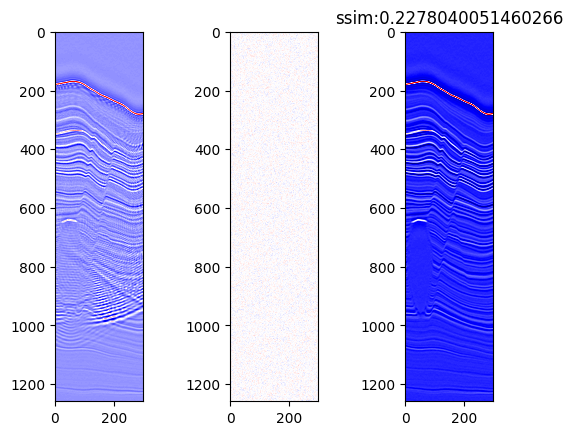

: 

In [27]:
for batch_inputs, batch_outputs in val_dataset.take(1):
    print(batch_inputs.shape)
    batch_no = 10
    i,j = batch_inputs[batch_no],batch_outputs[batch_no]
    i_rescaled = rescale_volume(i)
    j_rescaled = rescale_volume(j)
    i_expanded =  tf.expand_dims(i,axis=0) # so that the input will go as batch
    out = vit_mae_1_loaded.predict(i_expanded)
    out = tf.squeeze(out,axis=0)
    ssim_value_1 = tf.image.ssim(tf.expand_dims(out,axis=-1),tf.expand_dims(j_rescaled,axis=-1), max_val=1.0)
    

    print(i.shape)
    
    fig, axes = plt.subplots(1,3)
    ax0,ax1,ax2 = axes[0],axes[1],axes[2]
    ax0.imshow(i_rescaled,cmap='seismic',vmin=0,vmax=1)
    ax1.imshow(out,cmap='seismic',vmin=0,vmax=1)
    ax2.imshow(j_rescaled,cmap='seismic',vmin=0,vmax=1)
    plt.title(f"ssim:{ssim_value_1}")


    break




In [23]:
with open('vit_mae_1.pkl','rb') as f:
    h2 = pickle.load(f)

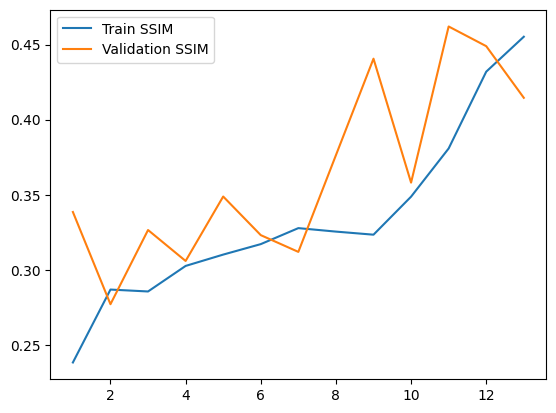

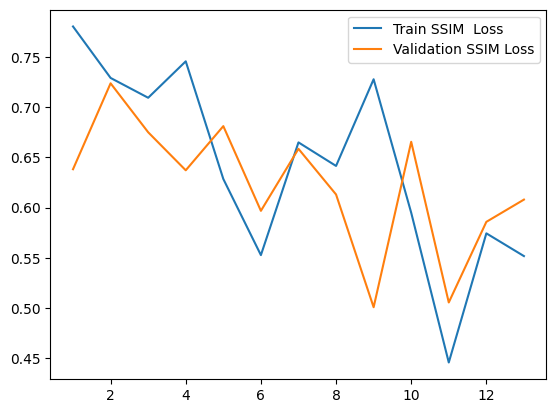

In [24]:
train_ssim = h2['ssim']
val_ssim = h2['val_ssim']
train_ssim_loss = h2['ssim_loss']
val_ssim_loss = h2['val_ssim_loss']
epochs = range(1,len(train_ssim)+1)
plt.figure()
plt.plot(epochs,train_ssim,label="Train SSIM")
plt.plot(epochs,val_ssim,label="Validation SSIM")
plt.legend()

plt.figure()
plt.plot(epochs,train_ssim_loss,label="Train SSIM  Loss")
plt.plot(epochs,val_ssim_loss,label="Validation SSIM Loss")
plt.legend()
